In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm 

from traffic.core import Traffic

/tmp/ipykernel_14381/251887701.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Generated
gen_to = Traffic.from_file("../deep_traffic_generation/data/generated_datasets/gen_takeoffs_LFPO_07.pkl")
gen_ldng = Traffic.from_file("../deep_traffic_generation/data/generated_datasets/gen_landings_LFPO_06.pkl")

#make every flight begin at the same time
base_ts = pd.Timestamp.today(tz = "UTC").round(freq='T')
gen_to.data = gen_to.data.assign(
    timestamp=pd.to_timedelta(gen_to.data.timedelta, unit="s") + base_ts
)
gen_ldng.data = gen_ldng.data.assign(
    timestamp=pd.to_timedelta(gen_ldng.data.timedelta, unit="s") + base_ts
)

gen_to.to_pickle("../deep_traffic_generation/data/generated_datasets/gen_takeoffs_LFPO_07.pkl")
gen_ldng.to_pickle("../deep_traffic_generation/data/generated_datasets/gen_landings_LFPO_06.pkl")

# Observed
obs_to = Traffic.from_file("../deep_traffic_generation/data/training_datasets/takeoffs_LFPO_07.pkl")
obs_ldng = Traffic.from_file("../deep_traffic_generation/data/training_datasets/landings_LFPO_06.pkl")

Output()

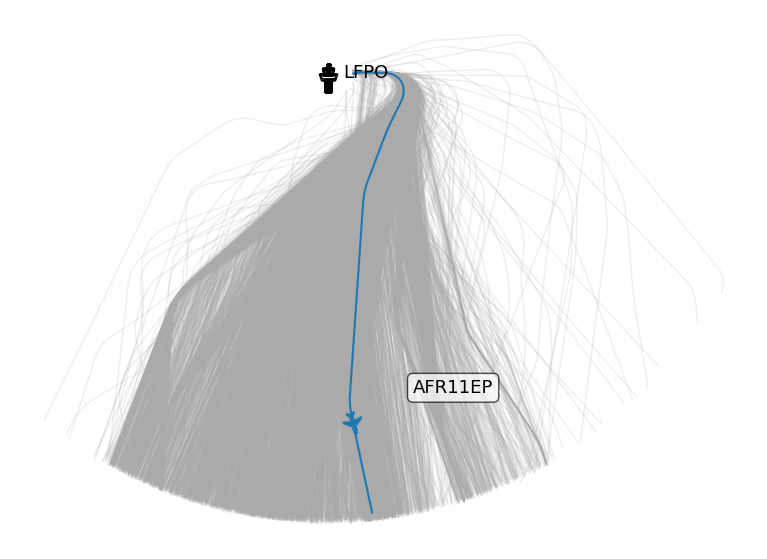

In [3]:
from traffic.core.projection import EuroPP
from traffic.data import airports

# Select only the relevant observed trajectories

last_track = obs_to.data.groupby("flight_id")["track"].last()
id_to_south = last_track[(last_track > 130) & (last_track < 210)].index
obs_to_south = obs_to[id_to_south]

#loops
def simple(flight):
    return flight.assign(simple=lambda x: flight.shape.is_simple)
obs_to_south = obs_to_south.iterate_lazy().pipe(simple).eval(desc ="")
obs_to_south = obs_to_south.query("simple")

obs_to_south.to_pickle("../deep_traffic_generation/data/training_datasets/takeoffs_south_LFPO_07.pkl")

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7), subplot_kw=dict(projection=EuroPP()))
    ax.figure

    obs_to_south.plot(ax, alpha=0.2)

    k =  np.random.choice(obs_to_south.flight_ids)
    obs_to_south[k].plot(ax, color="#1f77b4", lw=1.5)
    obs_to_south[k].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LFPO"].point.plot(ax)

    plt.show()


Output()

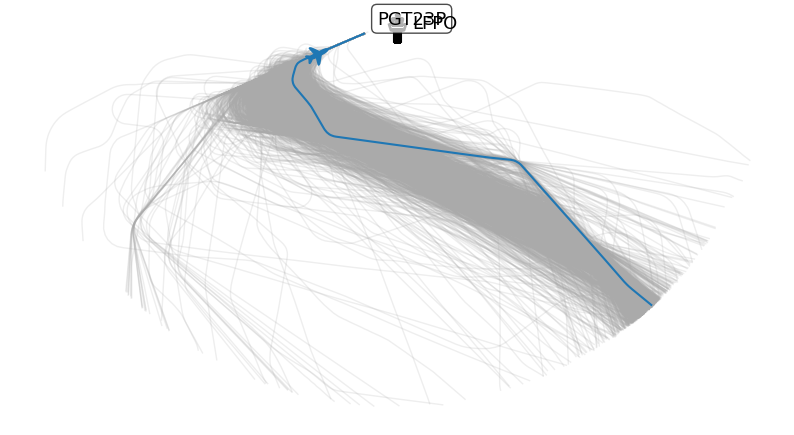

In [5]:
from traffic.core.projection import EuroPP
from traffic.data import airports

first_track = obs_ldng.data.groupby("flight_id")["track"].first()
id_from_south = first_track[first_track > 270].index
obs_ldng_south = obs_ldng[id_from_south]

#loops
def simple(flight):
    return flight.assign(simple=lambda x: flight.shape.is_simple)
obs_ldng_south = obs_ldng_south.iterate_lazy().pipe(simple).eval(desc ="")
obs_ldng_south = obs_ldng_south.query("simple")

obs_ldng_south = obs_ldng_south.query(
    "flight_id not in ['EZS25CN_2882']"
)

obs_ldng_south.to_pickle("../deep_traffic_generation/data/training_datasets/landings_south_LFPO_06.pkl")

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7), subplot_kw=dict(projection=EuroPP()))
    ax.figure

    obs_ldng_south.plot(ax, alpha=0.2)

    k =  np.random.choice(obs_ldng_south.flight_ids)
    obs_ldng_south[k].plot(ax, color="#1f77b4", lw=1.5)
    obs_ldng_south[k].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LFPO"].point.plot(ax)

    plt.show()

# Delta_t distribution estimation

## Max observed flight duration

In [6]:
from datetime import timedelta

max_duration = timedelta(0)

for f in tqdm(obs_to_south):
    d = f.duration
    if d > max_duration:
        max_duration = d

for f in tqdm(obs_ldng_south):
    d = f.duration
    if d > max_duration:
        max_duration = d

print(max_duration)

  0%|          | 0/5300 [00:00<?, ?it/s]

  0%|          | 0/3484 [00:00<?, ?it/s]

0 days 00:30:58


## Observed delta_t

In [7]:
start_landings = obs_ldng_south.data.groupby("flight_id")["timestamp"].first().sort_values()
stop_landings = obs_ldng_south.data.groupby("flight_id")["timestamp"].last()

start_takeoffs = obs_to_south.data.groupby("flight_id")["timestamp"].first().sort_values()
stop_takeoffs = obs_to_south.data.groupby("flight_id")["timestamp"].last()

In [27]:
import pandas as pd

delta_t = []

# first landings
for iL, tL in tqdm(start_landings.items()):
    for iT, tT in start_takeoffs.items():
        d = tL - tT

        #If delta_t is posiive, takeoff starts AFTER landing, and then delta_t cannot be larger than landing duration
        #If delta_t is negative, takeoff starts BEFORE landing, and then delta_t cannot be larger than takeoff duration (absolute value)
        if d < tT - stop_takeoffs[iT] or (d > stop_landings[iL] - tL):
            pass

        #make sure that delta_t is smaller than the total duration of the reference (the takeoff)
        elif d < stop_landings[iL] - tL: 
            delta_t.append({"takeoff": iT, "landing":iL, "delta_t":d.total_seconds()})

delta_t = pd.DataFrame(delta_t)

0it [00:00, ?it/s]

In [30]:
delta_t.to_pickle("../deep_traffic_generation/data/training_datasets/delta_t_LFPO_06_07.pkl")

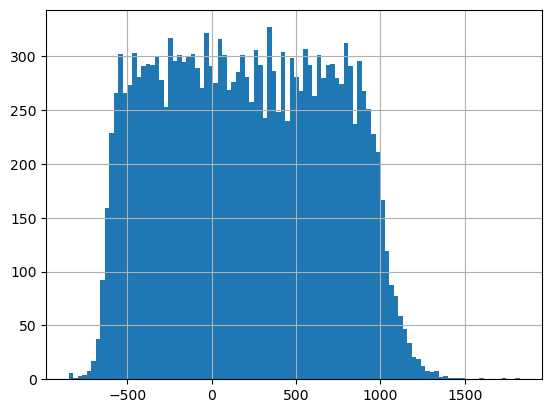

In [28]:
delta_t.delta_t.hist(bins = 100)
plt.show()

In [200]:
from scipy import stats
stats.kstest(delta_t.delta_t.values, stats.uniform(loc=delta_t.delta_t.values.min(), scale = delta_t.delta_t.values.max() - delta_t.delta_t.values.min()).cdf)

KstestResult(statistic=0.1320146895302543, pvalue=1.6991163772994978e-205)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KernelDensity

bandwidths = np.logspace(-1, 3, 10)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)
grid.fit(delta_t.delta_t.values[:, None])

grid.best_estimator_

KernelDensity(bandwidth=16.68100537200059)

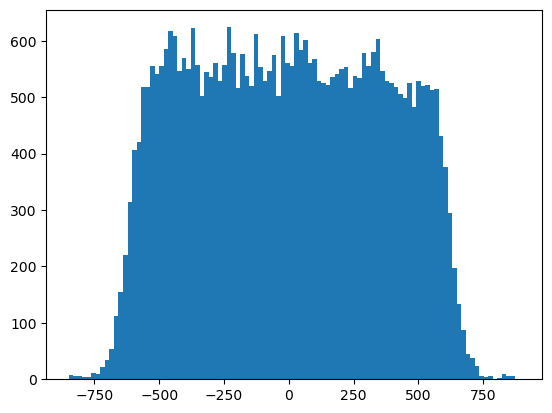

In [204]:
from sklearn.neighbors import KernelDensity

# According to crossvalidation: bandwith = 19.3
kde = KernelDensity(kernel="gaussian", bandwidth=19.3).fit(delta_t.delta_t.values[:,None])

# Sampling new delta_t from the kernel density estimation
plt.hist(kde.sample(39739), bins = 100)
plt.show()

# Pairs landing/takeoff generation

In [205]:
# If delta_t > 0 takeoff began before landing
# If delta_t < 0 takeoff began after landing

#start landing = start takeoff + delta_t

gen_pairs = pd.DataFrame(columns=["landing", "takeoff", "delta_t"])

gen_pairs.landing = np.random.choice(gen_ldng.flight_ids, 15000)
gen_pairs.takeoff = np.random.choice(gen_to.flight_ids, 15000)
gen_pairs.delta_t = kde.sample(15000)

In [214]:
gen_pairs["LoS"] = False

for i, r in tqdm(gen_pairs[:5000].iterrows()):

    ldg = gen_ldng.query(f"flight_id == '{r.landing}'")[0] #faster than gen_ldng[r.landging]
    to = gen_to.query(f"flight_id == '{r.takeoff}'")[0]

    if pd.to_timedelta(r.delta_t, unit="s") < to.duration:

        ldg.data = ldg.data.assign(
            timestamp=pd.to_timedelta(r.delta_t, unit="s") + ldg.data.timestamp
            )

        ldg = ldg.resample("1s")
        to = to.resample("1s")

        dist = to.distance(ldg)
        
        if dist is not None : 
            if dist.query("(lateral < 3) & (vertical < 2000)").shape[0] > 0:
                gen_pairs.iloc[i ,3] = True
                print("Los happend at ", i)
    else :
        gen_pairs.iloc[i ,3] = "delta_t too big"


0it [00:00, ?it/s]

Los happend at  137
Los happend at  157
Los happend at  1352
Los happend at  2720
Los happend at  4419
Los happend at  4698
Los happend at  4905
Los happend at  4996


In [216]:
gen_pairs.query("LoS == 'delta_t too big'")

,landing,takeoff,delta_t,LoS
97,TRAJ_8413,TRAJ_2356,611.665924,delta_t too big
271,TRAJ_1681,TRAJ_4231,575.814261,delta_t too big
279,TRAJ_1602,TRAJ_6816,641.592297,delta_t too big
408,TRAJ_8680,TRAJ_4379,620.072094,delta_t too big
413,TRAJ_165,TRAJ_2410,588.425525,delta_t too big
...,...,...,...,...
4763,TRAJ_6135,TRAJ_9419,579.424862,delta_t too big
4767,TRAJ_3222,TRAJ_4240,587.481243,delta_t too big
4783,TRAJ_5594,TRAJ_549,830.051741,delta_t too big
4854,TRAJ_6773,TRAJ_5153,595.731554,delta_t too big
